In [44]:
import os
from glob import glob
import math

import trimesh
import numpy as np
from scipy.interpolate import griddata
import scipy.ndimage as ndi
import scipy.spatial as spatial
from skimage.segmentation import watershed
from scipy.spatial.distance import cdist
from skimage.feature import peak_local_max

In [45]:
def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2) #range
    #ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0]) #azimuth
    return ptsnew

def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z

def convex_hull_volume(pts):
    ch = spatial.ConvexHull(pts)
    dt = spatial.Delaunay(pts[ch.vertices])
    tets = dt.points[dt.simplices]
    return np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                     tets[:, 2], tets[:, 3]))

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

In [46]:
#steps

#0 calculate centroid and recentre hail at centroid
#?? align to dmax
#1 convert vertices into spherical coordiantes
#2 interpolate onto regular grid
#3 plot

In [47]:
neighborhood_size = 7
lobe_radius_percentile = 50

In [56]:
#stl_ffn = '/home/meso/data/yalboroo_collection/hailstone09.stl'
stl_ffn = '/home/meso/data/brisbane_collection/hailstone_11.stl'
# load mesh
mymesh = trimesh.load_mesh(stl_ffn)
# volumetric center of mass which we can set as the origin for our mesh
mymesh.vertices -= mymesh.center_mass
# convert to spherical
ptsnew = appendSpherical_np(mymesh.vertices)
mymesh_azi = np.rad2deg(ptsnew[:,5])
mymesh_elv = np.rad2deg(ptsnew[:,4])
mymesh_rng = ptsnew[:,3]
perc_dist = np.percentile(mymesh_rng, lobe_radius_percentile) #percentile calculated from original mesh points
print(perc_dist)

# interpolate
grid_azi, grid_elv = np.meshgrid(np.arange(-180,180,1), np.arange(-90,90,1)) #azimuth, elevation
grid_rng = griddata((mymesh_azi, mymesh_elv), mymesh_rng, (grid_azi, grid_elv), method='linear')

# find local maximum
grid_rng_filt = np.copy(grid_rng)
nan_mask = np.isnan(grid_rng_filt)
grid_rng_filt[nan_mask]=0
max_coords = peak_local_max(grid_rng_filt, min_distance=neighborhood_size, threshold_abs=perc_dist, exclude_border=2)
grid_rng_filt[nan_mask]=-200
min_coords = peak_local_max(-grid_rng_filt, min_distance=neighborhood_size)
grid_rng_filt[nan_mask]=0

# min_rng_list = []
# for item in min_coords:
#     min_rng_list.append(grid_rng_filt[item[0],item[1]])
# perc_dist = np.mean(min_rng_list)
# print(perc_dist)

# run watershed
grid_rng_filt[grid_rng_filt<perc_dist]=0
mask = np.zeros(grid_rng_filt.shape, dtype=bool)
mask[tuple(max_coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-grid_rng_filt, markers, mask=grid_rng>=perc_dist)
labels_plot = labels.copy().astype(float)
labels_plot[labels_plot==0]=np.nan

# compute volume of each lobe using its convex hull
lobe_vol_list = []
for i in range(1, np.max(labels)+1):
    lobe_azi = grid_azi[labels==i]
    lobe_elv = grid_elv[labels==i]
    lobe_rng = grid_rng[labels==i]
    lobe_x, lobe_y, lobe_z = sph2cart(np.radians(lobe_azi), np.radians(lobe_elv), lobe_rng)
    if len(lobe_x)<10:
        print('skipping lobe', i, 'with', len(lobe_x), 'pts')
        continue
    lobe_pts = np.stack([lobe_x, lobe_y, lobe_z], axis=1)
    lobe_volume = convex_hull_volume(lobe_pts)
    lobe_vol_list.append(lobe_volume)
    
#calculate fraction of total volume
total_volume = mymesh.volume
lobe_total_volume = np.sum(lobe_vol_list)

print(f'radius for {lobe_radius_percentile}th percentile is: {perc_dist:.1f} mm')
print(f'lobe volume fraction: {lobe_total_volume/total_volume*100:.1f}%')
print(f'lobe volume stats: largest {np.max(lobe_vol_list):.1f} mm3, mean: {np.mean(lobe_vol_list):.1f} mm3, stdev: {np.std(lobe_vol_list):.1f} mm3')
print(f'number of lobes: {len(max_coords)}')

35.576028860353794
radius for 50th percentile is: 35.6 mm
lobe volume fraction: 23.5%
lobe volume stats: largest 9767.1 mm3, mean: 1277.8 mm3, stdev: 2360.6 mm3
number of lobes: 35


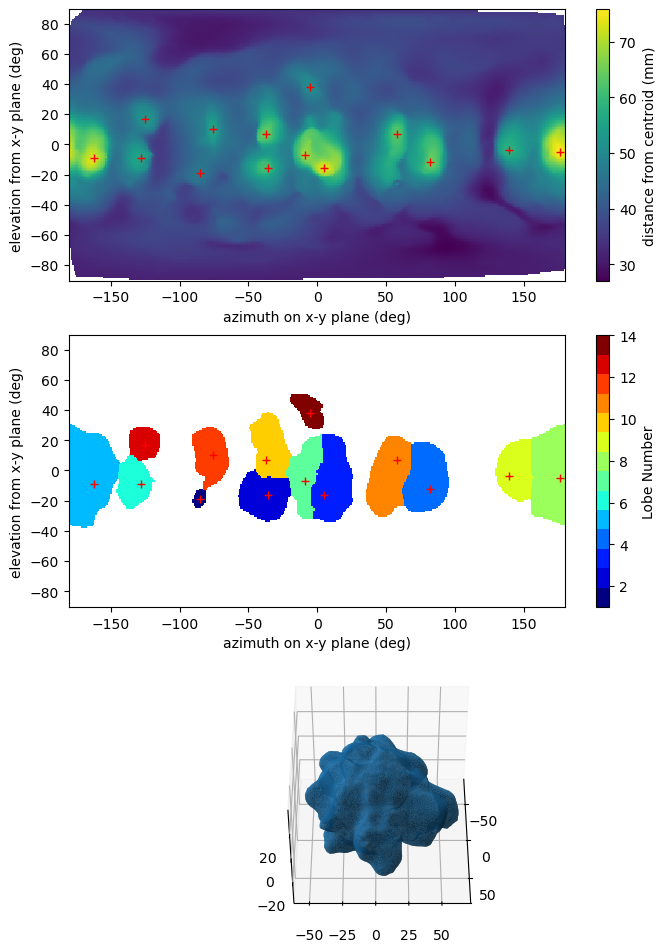

In [55]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[8,12])

plt.subplot(311)
plt.pcolor(grid_azi, grid_elv, grid_rng)
for item in max_coords:
    plt.plot(grid_azi[item[0],item[1]], grid_elv[item[0],item[1]], 'r+')  
plt.colorbar(label='distance from centroid (mm)')
plt.xlabel('azimuth on x-y plane (deg)')
plt.ylabel('elevation from x-y plane (deg)')

plt.subplot(312)
cmap = plt.cm.get_cmap('jet', len(max_coords))
plt.pcolor(grid_azi, grid_elv, labels_plot, cmap=cmap)
for item in max_coords:
    plt.plot(grid_azi[item[0],item[1]], grid_elv[item[0],item[1]], 'r+')  
plt.colorbar(label='Lobe Number')
plt.xlabel('azimuth on x-y plane (deg)')
plt.ylabel('elevation from x-y plane (deg)')

ax = fig.add_subplot(313, projection='3d')
ax.plot_trisurf(mymesh.vertices[:, 0], mymesh.vertices[:,1], triangles=mymesh.faces, Z=mymesh.vertices[:,2])
ax.view_init(elev=45, azim=0)

plt.savefig(os.path.basename(stl_ffn) + '.png')
plt.show()

In [23]:
scene = trimesh.Scene(mymesh)
scene.show()